# Intro to Models

In this lecture we will learn about **modeling** data for the first time. After this lesson, you should know what we generally mean by a "model", what linear regression is and how to interpret the output.
But first we need to introduce a new data type: *categorical variables*.

    
1. [Categorical variables](#Categorical-variables)
2. [Models](#Models)
   - [Tables as models](#Tables-as-models)
   - [Modeling Missing Values](#Modeling-Missing-Values)
   - [Linear Regression](#Linear-Regression)


Online Resources:

[Chapter 7.5](https://wesmckinney.com/book/data-cleaning.html#pandas-categorical) of our textbook introduces categorical variables.



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import default_rng
import warnings


In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [37]:
#!pip install gapminder
from gapminder import gapminder

In [38]:
gapminder.head()

,country,continent,year,lifeExp,pop,gdpPercap
0,Afghanistan,Asia,1952,28.801,8425333,779.445314
1,Afghanistan,Asia,1957,30.332,9240934,820.853030
2,Afghanistan,Asia,1962,31.997,10267083,853.100710
3,Afghanistan,Asia,1967,34.020,11537966,836.197138
4,Afghanistan,Asia,1972,36.088,13079460,739.981106


## Categorical variables

As a motivation, take another look at the gapminder data which contains variables of a **mixed type**: numeric columns along with string type columns which contain repeated instances of a smaller set of distinct or **discrete** values which 

1. are not numeric (but could be represented as numbers)
2. cannot really be ordered
3. typically take on a finite set of values, or *categories*.

We refer to these data types as **categorical**.

We have already seen functions like `unique` and `value_counts`, which enable us to extract the distinct values from an array and compute their frequencies.

Boxplots and grouping operations typically use a categorical variable to compute summaries of a numerical variables for each category separately, e.g.

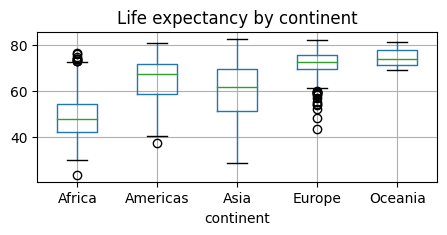

In [39]:
gapminder.boxplot(column = "lifeExp", by="continent",figsize=(5, 2));
plt.title('Life expectancy by continent')
# Remove the default suptitle
plt.suptitle("");

pandas has a special `Categorical` extension type for holding data that uses the integer-based categorical representation or encoding. This is a popular data compression technique for data with many occurrences of similar values and can provide significantly faster performance with lower memory use, especially for string data.

In [40]:
gapminder.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   country    1704 non-null   category
 1   continent  1704 non-null   object  
 2   year       1704 non-null   int64   
 3   lifeExp    1704 non-null   float64 
 4   pop        1704 non-null   int64   
 5   gdpPercap  1704 non-null   float64 
dtypes: category(1), float64(2), int64(2), object(1)
memory usage: 75.2+ KB


In [41]:
gapminder['country'] = gapminder['country'].astype('category')
gapminder.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   country    1704 non-null   category
 1   continent  1704 non-null   object  
 2   year       1704 non-null   int64   
 3   lifeExp    1704 non-null   float64 
 4   pop        1704 non-null   int64   
 5   gdpPercap  1704 non-null   float64 
dtypes: category(1), float64(2), int64(2), object(1)
memory usage: 75.2+ KB


We will come back to the usefulness of this later.



## Tables as models

For now let us look at our first "model":

In [42]:
titanic = sns.load_dataset('titanic')
titanic["class3"] = (titanic["pclass"]==3)
titanic["male"] = (titanic["sex"]=="male")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,class3,male
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,True,True
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,False,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,True,False
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False,False,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True,True,True


In [43]:
vals1, cts1 = np.unique(titanic["class3"], return_counts=True)
print(cts1)
print(vals1)

[400 491]
[False  True]


In [44]:
print("The mean survival on the Titanic was", np.mean(titanic.survived))

The mean survival on the Titanic was 0.3838383838383838


In [45]:
ConTbl = pd.crosstab(titanic["sex"], titanic["survived"])
ConTbl

survived,0,1
sex,,
female,81,233
male,468,109


What are the estimated survival probabilities?

In [46]:
#the good old groupby way:
bySex = titanic.groupby("sex").survived
bySex.mean()

sex
female    0.742038
male      0.188908
Name: survived, dtype: float64

In [47]:
p3D = pd.crosstab([titanic["sex"], titanic["class3"]], titanic["survived"])
p3D

survived         0    1
sex    class3          
female False     9  161
       True     72   72
male   False   168   62
       True    300   47

What are the estimated survival probabilities?

In [48]:
#the good old groupby way:
bySex = titanic.groupby(["sex", "class3"]).survived
bySex.mean()

sex     class3
female  False     0.947059
        True      0.500000
male    False     0.269565
        True      0.135447
Name: survived, dtype: float64

The above table can be looked at as a **model**, which is defined as a function which takes *inputs* **x** and "spits out" a *prediction*: 

$y = f(\mathbf{x})$

In our case, the inputs are $x_1=\text{sex}$, $x_2=\text{class3}$, and the output is the estimated survival probability!

It is evident that we could keep adding more *input* variables and make finer and finer grained predictions.

### Linear Models

In [49]:
lsFit = smf.ols('survived ~ sex:class3-1', titanic).fit()
lsFit.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
sex[female]:class3[False],0.9471,0.029,32.200,0.000,0.889,1.005
sex[male]:class3[False],0.2696,0.025,10.660,0.000,0.220,0.319
sex[female]:class3[True],0.5000,0.032,15.646,0.000,0.437,0.563
sex[male]:class3[True],0.1354,0.021,6.579,0.000,0.095,0.176


### Modeling Missing Values

We have already seen how to detect and how to replace missing values.
But the latter -until now- was rather crude: we often replaced all values with a "global" average.

Clearly, we can do better than replacing all missing entries in the *survived* column with the average $0.38$. 

In [50]:
rng = default_rng()

missingRows = rng.integers(0,890,20)
print(missingRows)
#introduce missing values
titanic.iloc[missingRows,0] = np.nan
np.sum(titanic.survived.isna())

[515 560 396 252 159 117 151 835 534 871 727 137 609 214 819 729 232 553
 727 432]


19

In [51]:
predSurv = lsFit.predict()
print( len(predSurv))
predSurv[titanic.survived.isna()]

891


array([0.26956522, 0.26956522, 0.94705882, 0.13544669, 0.13544669,
       0.26956522, 0.26956522, 0.5       , 0.94705882, 0.26956522,
       0.5       , 0.13544669, 0.13544669, 0.94705882, 0.5       ,
       0.5       , 0.13544669, 0.94705882, 0.94705882])

#### From categorical to numerical relations

In [52]:
url = "https://raw.githubusercontent.com/markusloecher/DataScience2018/master/data/Auto.csv"
auto = pd.read_csv(url)
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,Manufacturer
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,chevrolet
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,buick
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,plymouth
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst,amc
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino,ford


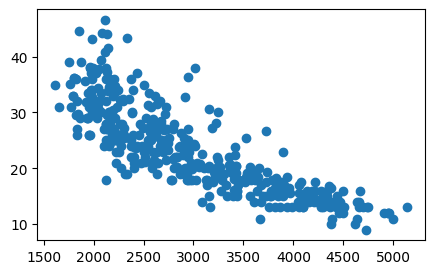

In [53]:
plt.figure(figsize=(5,3))
plt.scatter(x=auto["weight"], y=auto["mpg"]);

## Linear Regression

We can roughly estimate, i.e. "model" this relationship with a straight line:

$$
y = \beta_0 + \beta_1 x
$$

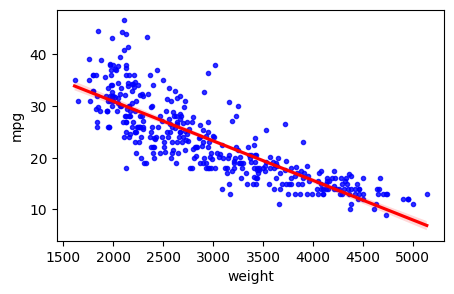

In [54]:
plt.figure(figsize=(5,3))
tmp=sns.regplot(x=auto["weight"], y=auto["mpg"], order=1, ci=95, 
                scatter_kws={'color':'b', 's':9}, line_kws={'color':'r'})

Remind yourself of the definition of the slope of a straight line

![SlopeIllustration](figures/IllustrationSlope.png)

$$
\beta_1 = \frac{\Delta y}{\Delta x} =  \frac{y_2-y_1}{x_2-x_1}
$$

In [55]:
est = smf.ols('mpg ~ weight', auto).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,46.2165,0.799,57.867,0.000,44.646,47.787
weight,-0.0076,0.000,-29.645,0.000,-0.008,-0.007


In [56]:
np.corrcoef(auto["weight"], auto["mpg"])

array([[ 1.        , -0.83224421],
       [-0.83224421,  1.        ]])

## Penguins


[Short description](https://lauranavarroviz.wordpress.com/2020/08/01/palmer-penguins/)

![penguin image](figures/Penguins_bill.png)

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

penguins = sns.load_dataset("penguins")
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


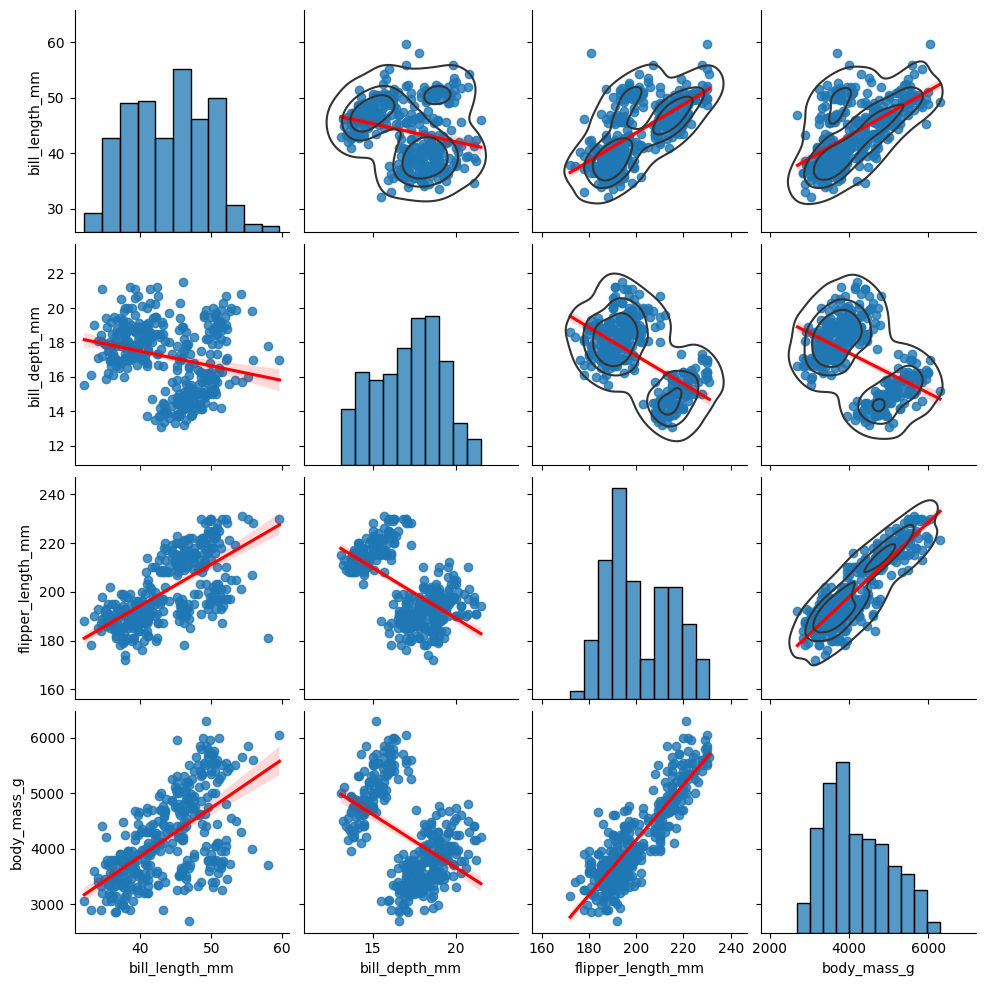

In [58]:
warnings.filterwarnings("ignore")

g=sns.pairplot(penguins, kind="reg", plot_kws={'line_kws':{'color':'red'}}, corner=False);#
g.map_upper(sns.kdeplot, levels=4, color=".2");
plt.show()

The "data tells us" that
* bill depth seems to **decrease** with bill length
* flipper length and body mass seem to **decrease** with bill depth.
* flipper length and body mass seem to **increase** with bill length.

Can we fit simple regression lines to prove our visual hypothesis?

In [59]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

lm1 = smf.ols('bill_depth_mm ~ bill_length_mm', penguins).fit()
lm1.summary().tables[1]

lm2 = smf.ols('flipper_length_mm ~ bill_depth_mm', penguins).fit()
lm2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,272.2190,5.413,50.294,0.000,261.573,282.865
bill_depth_mm,-4.1574,0.314,-13.261,0.000,-4.774,-3.541


BUT: the interpretation of the data is model dependent !
The data does not "tell the truth" by itself:

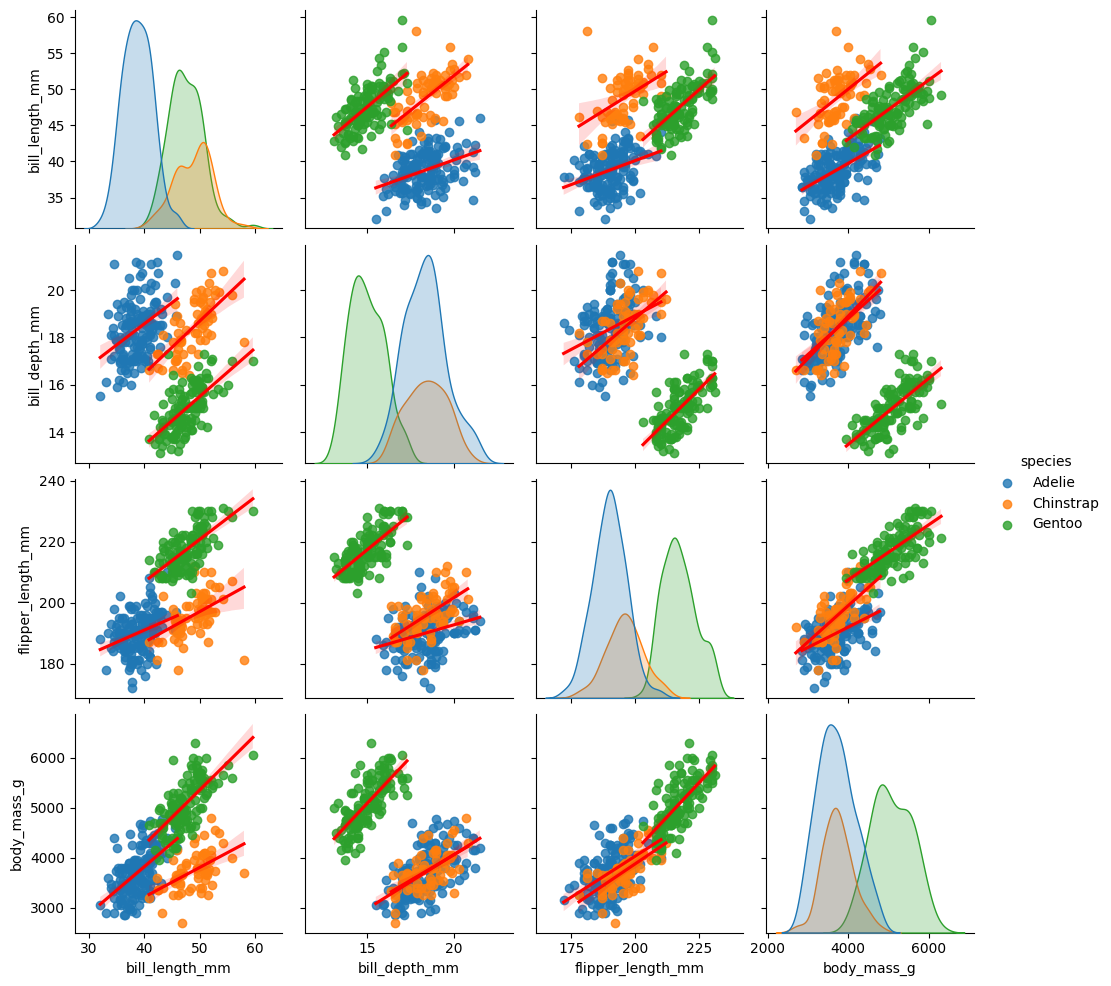

In [60]:
sns.pairplot(penguins,  hue="species", kind="reg", plot_kws={'line_kws':{'color':'red'}}, corner=False);
plt.show()

In [61]:
lm2a = smf.ols('flipper_length_mm ~ bill_depth_mm*species', penguins).fit()
lm2a.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,159.6189,6.943,22.990,0.000,145.962,173.276
species[T.Chinstrap],-30.9222,13.155,-2.351,0.019,-56.798,-5.046
species[T.Gentoo],-12.3945,10.439,-1.187,0.236,-32.928,8.139
bill_depth_mm,1.6534,0.378,4.379,0.000,0.911,2.396
bill_depth_mm:species[T.Chinstrap],1.9907,0.714,2.790,0.006,0.587,3.394
bill_depth_mm:species[T.Gentoo],3.0163,0.642,4.698,0.000,1.754,4.279


## Grouping with multiple categories

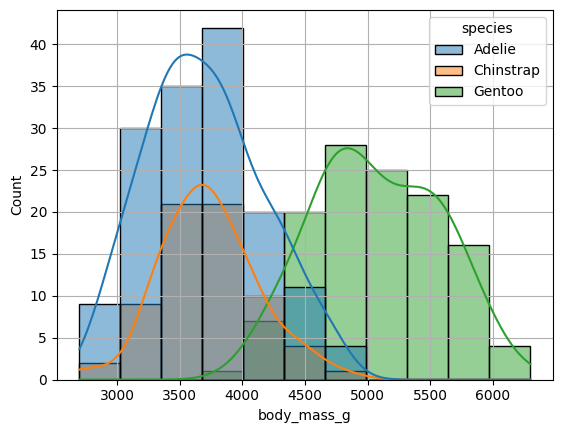

In [7]:
warnings.filterwarnings("ignore")

sns.histplot(data=penguins, x="body_mass_g", kde=True, hue = "species");plt.grid();

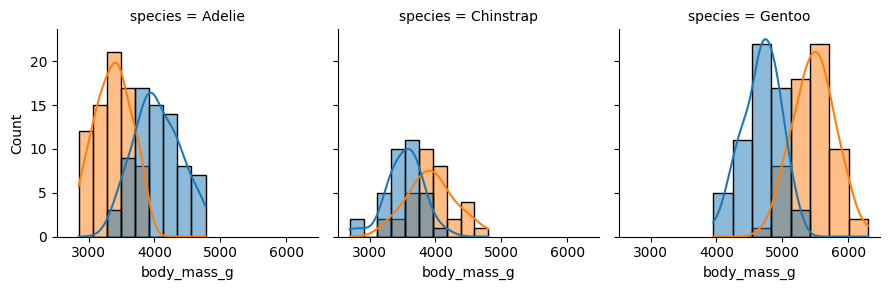

In [8]:
g = sns.FacetGrid(penguins, col="species")
g.map_dataframe(sns.histplot, x="body_mass_g",  hue = "sex", kde=True);

--------------------------


Further Reading:

- []()